In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style(style='darkgrid')

import plotly.express as px

from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import tree
from sklearn import metrics as mtr

from IPython.display import Image as img
import subprocess

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.4f}'.format        

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
df = pd.read_csv('online_shoppers_intention.csv') 

In [5]:
df.rename(columns={'Administrative':'Admin','Administrative_Duration':'Admin_dur','Informational':'Info','Informational_Duration':'Info_dur',
                   'ProductRelated':'Prod','ProductRelated_Duration':'Prod_dur','SpecialDay':'Spl_Prxmty','OperatingSystems':'OS'}, inplace=True)

In [6]:
# Data for Browser 11 & 9 are dropped considering the smaller number of occurences which shouldn't influence the results

df1 = df.drop(df[((df.Browser == 9) | (df.Browser == 11) )].index, axis=0)

In [7]:
# Data for TrafficTypes 16,12,17 are dropped considering the smaller number of occurences which shouldn't influence the results

df1.drop(df1[(df1.TrafficType == 17) | (df1.TrafficType == 12) | (df1.TrafficType == 16)].index,axis=0, inplace=True)

In [37]:
# replaceStruct = {
#     'OS':{1:'OS_1',2:'OS_2',3:'OS_3',4:'OS_4',5:'OS_5',6:'OS_6',7:'OS_7',8:'OS_8'},
#     'Broswer':{1:'Browser_1',2:'Browser_2',3:'Browser_3',4:'Browser_4',5:'Browser_5',6:'Browser_6',7:'Browser_7',
#                8:'Browser_8',9:'Browser_9',10:'Browser_10',11:'Browser_11',12:'Browser_12',13:'Browser_13'},
#     'Region':{1:'Region_1',2:'Region_2',3:'Region_3',4:'Region_4',5:'Region_5',6:'Region_6',7:'Region_7',8:'Region_8',9:'Region_9'},
#     'TrafficType':{1:'TrTyp_1',2:'TrTyp_2',3:'TrTyp_3',4:'TrTyp_4',5:'TrTyp_5',6:'TrTyp_6',7:'TrTyp_7',8:'TrTyp_8',
#                    9:'TrTyp_9',10:'TrTyp_10',11:'TrTyp_11',12:'TrTyp_12',13:'TrTyp_13',14:'TrTyp_14',15:'TrTyp_15',16:'TrTyp_16',
#                    17:'TrTyp_17',18:'TrTyp_18',19:'TrTyp_19',20:'TrTyp_20'},
#     'Weekend':{False:'No',True:'Yes'}
# }

In [38]:
# df1.replace(replaceStruct, inplace=True)

In [9]:
for col in {'OS','Browser','Region','TrafficType','Weekend','Month','VisitorType'}:
    df1[col] = df1[col].astype('category')

df1.Revenue = df1.Revenue.astype('int64')
# df1.head(10)

In [10]:
df1 = pd.get_dummies(df1,columns={'Month','OS','Browser','Region','TrafficType','VisitorType','Weekend'})

In [11]:
# df1.describe(include='all').T

In [12]:
dfy = df1['Revenue'].copy()
dfX = df1.drop('Revenue', axis=1).copy()

## Using CV for validating dataset class imbalance

In [13]:
from sklearn.model_selection import cross_val_score
dtree = dtc(criterion='entropy',splitter='best')

scores = cross_val_score(dtree, dfX, dfy, cv=10)
print(scores,'\n')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.86931818 0.89529221 0.90340909 0.87175325 0.875      0.78652597
 0.81493506 0.81818182 0.84809098 0.79528838] 

Accuracy: 0.85 (+/- 0.08)


In [14]:
scores = cross_val_score(dtree, dfX, dfy, cv=10, scoring='f1_macro')
print(scores,'\n')
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.64290691 0.78306779 0.80892877 0.71321496 0.75056604 0.64611983
 0.66840335 0.69203688 0.70984855 0.65179217] 

F1 score: 0.71 (+/- 0.11)


## Splitting train & test dataset

In [15]:
dfX_tr,dfX_ts,dfy_tr,dfy_ts = tts(dfX, dfy, test_size=0.3, random_state=6)

In [16]:
dfy_ts.value_counts(normalize=True)*100

0   84.5238
1   15.4762
Name: Revenue, dtype: float64

## 1) DecisionTreeClassifier Model & Choosing the best Hyper parameters based on GridSearchCV

In [67]:
param_grid = {
    'criterion':['entropy','gini'],
    'splitter':['best','random'],
#     'min_impurity_decrease':[0.01,0.015,0.02,0.025,0.035,0.05,0.1,0.15,0.2]
    'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20,30,50],
}

grid = GridSearchCV(dtc(),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s


Best Params :  {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3124
           1       0.79      0.52      0.63       572

    accuracy                           0.90      3696
   macro avg       0.85      0.75      0.79      3696
weighted avg       0.90      0.90      0.90      3696

----

Best score: 0.794
DecisionTreeClassifier(max_depth=4)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.0s finished


0.9038506147065646
0.9042207792207793


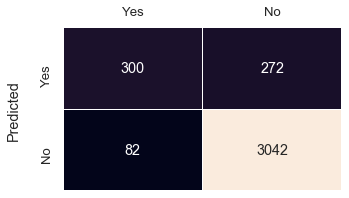

In [17]:
# dtree = dtc(criterion='entropy',splitter='best',min_impurity_decrease=0.01 )
dtree = dtc(criterion='gini',splitter='best',max_depth=4 )

dtree.fit(dfX_tr, dfy_tr)
print(dtree.score(dfX_tr, dfy_tr))
print(dtree.score(dfX_ts, dfy_ts))

y_pred1 = dtree.predict(dfX_ts)
cmat1 = mtr.confusion_matrix(dfy_ts,y_pred1, labels=[1,0])
dfcm1 = pd.DataFrame(cmat1, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm1, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [41]:
npcm1 = np.array(cmat1)
print('Accuracy of the model : ',npcm1.trace()/npcm1.sum())
print('Recall of the model : ',npcm1[0,0]/npcm1[:,0].sum())
print('Precision of the model : ',npcm1[0,0]/npcm1[0].sum())

appr1 = np.array([[npcm1.trace()/npcm1.sum()],[npcm1[0,0]/npcm1[:,0].sum()],[npcm1[0,0]/npcm1[0].sum()]])

Accuracy of the model :  0.9042207792207793
Recall of the model :  0.7853403141361257
Precision of the model :  0.5244755244755245


## 2) Bagging (Bootstrap Aggregating)

In [21]:
from sklearn.ensemble import BaggingClassifier

In [65]:
param_grid = {
    'n_estimators':[5,10,15,20,30,50,75,100],
    'max_features':[1,2,3,4,5,6,8,10,12,15,20,25]
}

grid = GridSearchCV(BaggingClassifier(),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)



Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 343 tasks      | elapsed:   13.9s


Best Params :  {'max_features': 20, 'n_estimators': 5}
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3124
           1       0.53      0.15      0.23       572

    accuracy                           0.85      3696
   macro avg       0.69      0.56      0.57      3696
weighted avg       0.81      0.85      0.81      3696

----

Best score: 0.643
BaggingClassifier(max_features=20, n_estimators=5)


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   31.4s finished


0.9479239155648341
0.8425324675324676


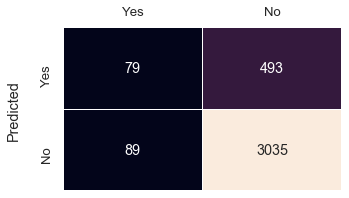

In [22]:
bgcl = BaggingClassifier(n_estimators=5 ,max_features=20)
bgcl = bgcl.fit(dfX_tr, dfy_tr)

print(bgcl.score(dfX_tr , dfy_tr))
print(bgcl.score(dfX_ts , dfy_ts))

y_pred2 = bgcl.predict(dfX_ts)
cmat2 = mtr.confusion_matrix(dfy_ts,y_pred2, labels=[1,0])
dfcm2 = pd.DataFrame(cmat2, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm2, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [36]:
npcm2 = np.array(cmat2)
print('Accuracy of the model : ',npcm2.trace()/npcm2.sum())
print('Recall of the model : ',npcm2[0,0]/npcm2[:,0].sum())
print('Precision of the model : ',npcm2[0,0]/npcm2[0].sum())

appr2 = np.array([[npcm2.trace()/npcm2.sum()],[npcm2[0,0]/npcm2[:,0].sum()],[npcm2[0,0]/npcm2[0].sum()]])

Accuracy of the model :  0.8425324675324676
Recall of the model :  0.47023809523809523
Precision of the model :  0.1381118881118881


## 3) AdaBoosting (Adaptive Boosting)

In [27]:
from sklearn.ensemble import AdaBoostClassifier

dtr1 = dtc(criterion='gini',splitter='best',max_depth=1)
dtr2 = dtc(criterion='gini',splitter='best',max_depth=2)
dtr4 = dtc(criterion='gini',splitter='best',max_depth=4)


In [89]:

param_grid = {
    'base_estimator':[dtr1,dtr2,dtr4],
    'n_estimators':[5,10,15,20,30,50,75,100],
    'learning_rate':[0.05,0.08,0.1,0.2,0.3,0.4,0.5,0.7,1.0],
    'algorithm':['SAMME','SAMME.R']
}

grid = GridSearchCV(AdaBoostClassifier(),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  5.5min finished


Best Params :  {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.08, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3124
           1       0.77      0.59      0.67       572

    accuracy                           0.91      3696
   macro avg       0.85      0.78      0.81      3696
weighted avg       0.90      0.91      0.91      3696

----

Best score: 0.802
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.08)


0.9119693806541406
0.9099025974025974


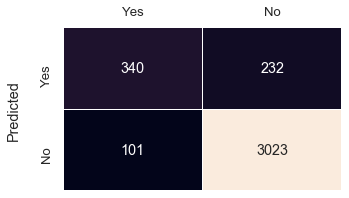

In [28]:

abcl = AdaBoostClassifier(algorithm='SAMME', base_estimator=dtr4 ,learning_rate=0.08)

abcl = abcl.fit(dfX_tr, dfy_tr)
print(abcl.score(dfX_tr , dfy_tr))
print(abcl.score(dfX_ts , dfy_ts))

y_pred3 = abcl.predict(dfX_ts)
cmat3 = mtr.confusion_matrix(dfy_ts,y_pred3, labels=[1,0])
dfcm3 = pd.DataFrame(cmat3, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm3, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [37]:
npcm3 = np.array(cmat3)
print('Accuracy of the model : ',npcm3.trace()/npcm3.sum())
print('Recall of the model : ',npcm3[0,0]/npcm3[:,0].sum())
print('Precision of the model : ',npcm3[0,0]/npcm3[0].sum())

appr3 = np.array([[npcm3.trace()/npcm3.sum()],[npcm3[0,0]/npcm3[:,0].sum()],[npcm3[0,0]/npcm3[0].sum()]])

Accuracy of the model :  0.9099025974025974
Recall of the model :  0.7709750566893424
Precision of the model :  0.5944055944055944


## 4) Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
# param_grid = {
#     'loss':['deviance', 'exponential'],
#     'learning_rate':[0.05,0.08,0.1,0.2,0.3,0.4,0.5,0.7,1.0],
#     'n_estimators':[5,10,15,20,30,50,75,100],
#     'subsample':[0.1,0.2,0.3,0.4,0.5,0.7,1.0],
#     'criterion' : ['friedman_mse', 'mse', 'mae'],
#     'max_depth':[1,2,3,4,5,6,7,8,9,10,12,15,20,30,50],
#     'min_impurity_decrease':[0.01,0.015,0.02,0.025,0.035,0.05,0.1,0.15,0.2],
#     'max_features':['auto', 'sqrt', 'log2','']
# #     'max_features':['auto', 'sqrt', 'log2','',5,8,10,12,15,20,25,35,50]
# }

param_grid = {
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.05,0.1,0.5,1.0],
    'n_estimators':[40,50,60],
    'subsample':[0.1,0.2,0.5,1.0],
    'criterion' : ['friedman_mse', 'mse', 'mae'],
    'max_depth':[1,5,10,20,50],
    'min_impurity_decrease':[0.1,0.15,0.2],
    'max_features':['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)


Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best Params :  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 0.2, 'n_estimators': 60, 'subsample': 0.2}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3124
           1       0.73      0.57      0.64       572

    accuracy                           0.90      3696
   macro avg       0.83      0.77      0.79      3696
weighted avg       0.89      0.90      0.90      3696

----

Best score: 0.801
GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='auto',
                           min_impurity_decrease=0.2, n_estimators=60,
                           subsample=0.2)


0.914173045697054
0.9023268398268398


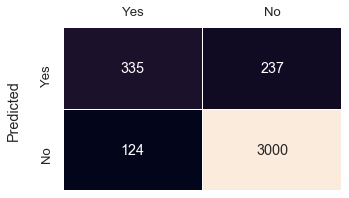

In [31]:
gbcl = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='exponential', max_depth=5, max_features='auto', min_impurity_decrease=0.2, n_estimators=60, subsample=0.2)
gbcl = gbcl.fit(dfX_tr, dfy_tr)

print(gbcl.score(dfX_tr , dfy_tr))
print(gbcl.score(dfX_ts , dfy_ts))

y_pred4 = gbcl.predict(dfX_ts)
cmat4 = mtr.confusion_matrix(dfy_ts,y_pred4, labels=[1,0])
dfcm4 = pd.DataFrame(cmat4, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm4, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [38]:
npcm4 = np.array(cmat4)
print('Accuracy of the model : ',npcm4.trace()/npcm4.sum())
print('Recall of the model : ',npcm4[0,0]/npcm4[:,0].sum())
print('Precision of the model : ',npcm4[0,0]/npcm4[0].sum())

appr4 = np.array([[npcm4.trace()/npcm4.sum()],[npcm4[0,0]/npcm4[:,0].sum()],[npcm4[0,0]/npcm4[0].sum()]])

Accuracy of the model :  0.9023268398268398
Recall of the model :  0.7298474945533769
Precision of the model :  0.5856643356643356


## 5) RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
param_grid = {
    'n_estimators':[48,50,52],
    'criterion':['gini','entropy'],
    'max_depth':[1,2],
    'max_features':['auto','sqrt','log2'],
    'min_impurity_decrease':[0.18,0.19,0.2],
    'class_weight':['balanced','balanced_subsample']
}

grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   51.1s finished


Best Params :  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_impurity_decrease': 0.18, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3124
           1       0.58      0.82      0.68       572

    accuracy                           0.88      3696
   macro avg       0.77      0.86      0.80      3696
weighted avg       0.91      0.88      0.89      3696

----

Best score: 0.790
RandomForestClassifier(class_weight='balanced_subsample', max_depth=1,
                       min_impurity_decrease=0.18, n_estimators=50)


0.8702157272094642
0.8806818181818182


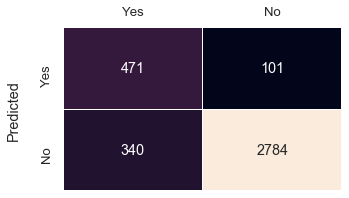

In [34]:
rfcl = RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', max_features='auto', min_impurity_decrease= 0.18, n_estimators=50)
rfcl = rfcl.fit(dfX_tr, dfy_tr)

print(rfcl.score(dfX_tr , dfy_tr))
print(rfcl.score(dfX_ts , dfy_ts))

y_pred5 = rfcl.predict(dfX_ts)
cmat5 = mtr.confusion_matrix(dfy_ts,y_pred5, labels=[1,0])
dfcm5 = pd.DataFrame(cmat5, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm5, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [39]:
npcm5 = np.array(cmat5)
print('Accuracy of the model : ',npcm5.trace()/npcm5.sum())
print('Recall of the model : ',npcm5[0,0]/npcm5[:,0].sum())
print('Precision of the model : ',npcm5[0,0]/npcm5[0].sum())

appr5 = np.array([[npcm5.trace()/npcm5.sum()],[npcm5[0,0]/npcm5[:,0].sum()],[npcm5[0,0]/npcm5[0].sum()]])


Accuracy of the model :  0.8806818181818182
Recall of the model :  0.5807644882860666
Precision of the model :  0.8234265734265734


## 6) XGBoost

In [47]:
from xgboost import XGBClassifier

In [58]:
param_grid = {
    'max_depth':[3,4,6],
#     'learning_rate':[0.05,0.1,0.2],
    'min_child_weight':[12,14],
    'gamma':[1.5,2,3],
#     'n_estimators':[40,50,60],
    'max_delta_step':[0,1,2],
    'subsample':[0.7,0.8],
    'colsample_bytree':[0.5,1.0,2.0],
    'reg_lambda':[0.8,1.0,1.2]
#     'scale_pos_weight':[0.2,0.5,1.0,3.0]
}

grid = GridSearchCV(XGBClassifier(objective='binary:logistic', learning_rate=0.1,n_estimators=60),param_grid,refit=True, verbose=True, n_jobs=-1, scoring='f1_macro')
gfit = grid.fit(dfX_tr,dfy_tr)

# print best parameter after tuning 
print('Best Params : ',grid.best_params_) 
grid_predictions = grid.predict(dfX_ts) 
   
# print classification report 
print(mtr.classification_report(dfy_ts, grid_predictions)) 

print("----\n")

print("Best score: %0.3f" % gfit.best_score_)
print(gfit.best_estimator_)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  9.4min finished


Best Params :  {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 12, 'reg_lambda': 0.8, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3124
           1       0.75      0.58      0.66       572

    accuracy                           0.91      3696
   macro avg       0.84      0.77      0.80      3696
weighted avg       0.90      0.91      0.90      3696

----

Best score: 0.803
XGBClassifier(colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=12,
              n_estimators=60, reg_lambda=0.8, subsample=0.7)


In [ ]:
xgbcl = XGBClassifier()
xgbcl = xcbl.fit(dfX_tr, dfy_tr)

print(xgbcl.score(dfX_tr , dfy_tr))
print(xgbcl.score(dfX_ts , dfy_ts))

y_pred6 = xgbcl.predict(dfX_ts)
cmat6 = mtr.confusion_matrix(dfy_ts,y_pred6, labels=[1,0])
dfcm6 = pd.DataFrame(cmat6, index=['Yes','No'],columns=['Yes','No'])
plt.figure(figsize=[5,3])
sns.set(font_scale=1.2)
fig = sns.heatmap(dfcm6, annot=True, fmt='d',linewidth=0.5, cbar=False)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.ylabel('Predicted\n')
plt.show()

In [46]:
compare = pd.DataFrame('',index=['Accuracy','Recall','Precision'],columns=['DTC','Bagging','AdaBoost','GradBoost','RandomForest'])
compare.DTC = appr1
compare.Bagging = appr2
compare.AdaBoost = appr3
compare.GradBoost = appr4
compare.RandomForest = appr5

cmpr = compare.T
cmpr = compare.reset_index()
cmpr = cmpr.melt(id_vars='index',value_vars=['DTC','Bagging','AdaBoost','GradBoost','RandomForest'], var_name='Model',value_name='Value')
cmpr

fig = px.line(cmpr, x='Model', y='Value', color='index', range_y=[0.0,1.1], width=1000, height=600)
fig.data[0].update(mode='markers+lines')
fig.data[1].update(mode='markers+lines')
fig.data[2].update(mode='markers+lines')

fig.show()
